In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ===============================
# File paths
# ===============================

doh_tunnel_iodine = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/iodine/all_pcaps_allN.csv"
doh_tunnel_dns2tcp = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dns2tcp/all_pcaps_allN.csv"
doh_tunnel_dnscat2 = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dnscat2/all_pcaps_allN.csv"

dga_malware_google = "/home/ubuntu/DoH_DGA_training/datasets/DGA_Google/all_pcaps_allN.csv"
dga_malware_clouflare = "/home/ubuntu/DoH_DGA_training/datasets/DGA_CF/all_pcaps_allN.csv"
dga_malware_adguard = "/home/ubuntu/DoH_DGA_training/datasets/DGA_ADGuard/all_pcaps_allN.csv"

nondoh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_nondoh.csv"

doh_benign_file = "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_doh.csv"

# ===============================
# Load datasets
# ===============================
df_doh_tunnel_iodine = pd.read_csv(doh_tunnel_iodine)
df_doh_tunnel_dns2tcp = pd.read_csv(doh_tunnel_dns2tcp)
df_doh_tunnel_dnscat2 = pd.read_csv(doh_tunnel_dnscat2)
df_doh_tunnel = pd.concat([df_doh_tunnel_iodine, df_doh_tunnel_dns2tcp, df_doh_tunnel_dnscat2], ignore_index=True)

df_dga_google = pd.read_csv(dga_malware_google)
df_dga_clouflare = pd.read_csv(dga_malware_clouflare)
df_dga_adguard = pd.read_csv(dga_malware_adguard)
df_dga = pd.concat([df_dga_google, df_dga_clouflare, df_dga_adguard], ignore_index=True)

df_nondoh_benign = pd.read_csv(nondoh_benign_file)
df_doh_benign = pd.read_csv(doh_benign_file)

# ===============================
# Assign labels
# ===============================
df_dga["label"] = "DGA"
df_doh_tunnel["label"] = "DoH_Tunnel"
df_nondoh_benign["label"] = "NonDoH_Benign"
df_doh_benign["label"] = "DoH_Benign"

# ===============================
# Combine all into one DataFrame
# ===============================
df_all = pd.concat(
    [df_dga, df_doh_tunnel, df_nondoh_benign, df_doh_benign, df_doh_benign],
    ignore_index=True
)


print("DGA_shape:", df_dga.shape)
print("DoH_Tunnel shape:", df_doh_tunnel.shape)
print("NonDoH_Benign shape:", df_nondoh_benign.shape)
print("DoH_Benign shape:", df_doh_benign.shape)

print("\nFinal dataset shape:", df_all.shape)
print("Labels distribution:\n", df_all["label"].value_counts())
print("Columns:\n", list(df_all.columns))


DGA_shape: (305136, 35)
DoH_Tunnel shape: (707228, 35)
NonDoH_Benign shape: (2139204, 36)
DoH_Benign shape: (116412, 36)

Final dataset shape: (3384392, 36)
Labels distribution:
 label
NonDoH_Benign    2139204
DoH_Tunnel        707228
DGA               305136
DoH_Benign        232824
Name: count, dtype: int64
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max', 'label', 'source_pcap']


In [3]:
N_value = 16   # <-- change this to 8, 16, 32, 64 as needed
df_subset = df_all[df_all["N"] == N_value].copy()

print(f"\nTraining on N={N_value}, dataset size={df_subset.shape[0]}")

# Separate features and target
y = df_subset["label"]
X = df_subset.drop(columns=[
    "label", 'session_id', 'client_ip', 'server_ip', 
    'client_port', 'server_port', 'protocol', 'N',
    'pcap_file', 'source_pcap'
], errors="ignore")
feature_names = X.columns.tolist()
# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Remaining feature columns:\n", list(X.columns))
print("Target classes:", y.unique())


Training on N=16, dataset size=846098
Remaining feature columns:
 ['n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'pkt_fraction_client', 'bytes_fraction_client', 'flow_duration', 'time_first_response', 'dir_switches', 'size_min', 'size_mean', 'size_max', 'iat_min', 'iat_mean', 'iat_max']
Target classes: ['DGA' 'DoH_Tunnel' 'NonDoH_Benign' 'DoH_Benign']


In [4]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Train MLP
# Extended MLP with more options
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # deeper network with 3 hidden layers
    activation="relu",                  # alternatives: 'tanh', 'logistic'
    solver="adam",                      # alternatives: 'sgd', 'lbfgs'
    alpha=1e-4,                         # L2 regularization (weight decay)
    batch_size=64,                      # mini-batch size
    learning_rate="adaptive",           # 'constant', 'invscaling', 'adaptive'
    learning_rate_init=0.001,           # initial learning rate
    max_iter=500,                       # train longer
    shuffle=True,                       # shuffle samples every epoch
    early_stopping=True,                # stop if validation score doesn’t improve
    validation_fraction=0.1,            # use 10% of training for validation
    n_iter_no_change=20,                # patience for early stopping
    random_state=42,                    # reproducibility
    verbose=True                        # print progress during training
)

mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

Iteration 1, loss = 0.08702055
Validation score: 0.986054
Iteration 2, loss = 0.03519209
Validation score: 0.988873
Iteration 3, loss = 0.02907881
Validation score: 0.990140
Iteration 4, loss = 0.02632524
Validation score: 0.994378
Iteration 5, loss = 0.02472890
Validation score: 0.992638
Iteration 6, loss = 0.02328151
Validation score: 0.996167
Iteration 7, loss = 0.02136613
Validation score: 0.992200
Iteration 8, loss = 0.02104067
Validation score: 0.992976
Iteration 9, loss = 0.01940847
Validation score: 0.992638
Iteration 10, loss = 0.02029944
Validation score: 0.993263
Iteration 11, loss = 0.01848808
Validation score: 0.996150
Iteration 12, loss = 0.01727115
Validation score: 0.992200
Iteration 13, loss = 0.01875380
Validation score: 0.996150
Iteration 14, loss = 0.01835654
Validation score: 0.997079
Iteration 15, loss = 0.01818848
Validation score: 0.997282
Iteration 16, loss = 0.01782996
Validation score: 0.993770
Iteration 17, loss = 0.01685834
Validation score: 0.993888
Iterat

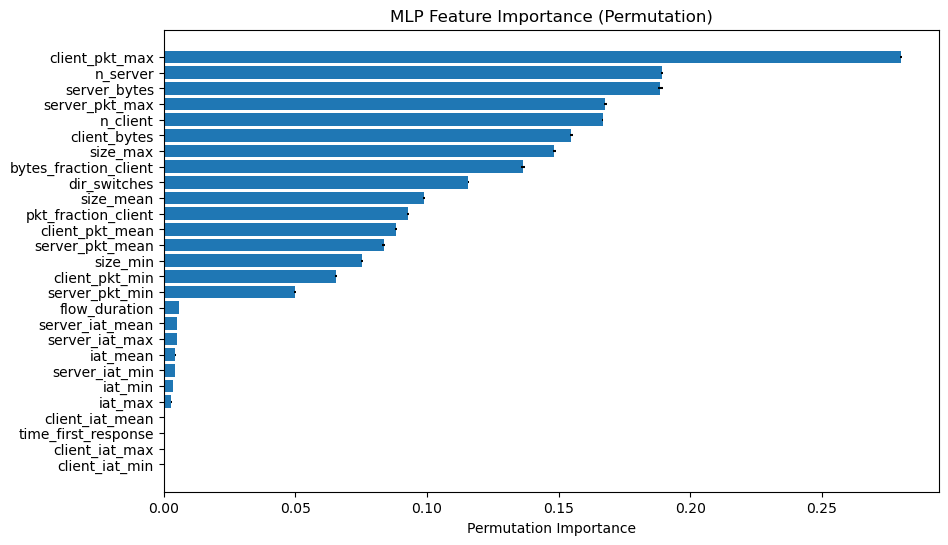

In [6]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np
# --- Create generic feature names ---
#feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Compute permutation importance on test set
result = permutation_importance(
    mlp, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Sort by importance
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    xerr=result.importances_std[sorted_idx]
)
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("MLP Feature Importance (Permutation)")
plt.show()


In [11]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Use a small background set for SHAP (to speed up kernel explainer)
background = shap.utils.sample(X_train, 200, random_state=42)

# Create SHAP Kernel Explainer (model-agnostic, works for sklearn MLP)
explainer = shap.KernelExplainer(mlp.predict_proba, background)

# Explain predictions on a sample of test set (to save time)
X_sample = shap.utils.sample(X_test, 300, random_state=42)

# Compute shap values (multiclass: list of arrays, one per class)
shap_values = explainer.shap_values(X_sample)


/home/ubuntu/miniconda/envs/jupyterenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [01:07<00:00,  4.43it/s]


client_pkt_max           0.050177
n_client                 0.029503
server_bytes             0.028473
server_pkt_max           0.022038
bytes_fraction_client    0.019350
size_max                 0.019342
client_bytes             0.019268
n_server                 0.017337
client_pkt_mean          0.014205
dir_switches             0.012115
client_pkt_min           0.009162
size_mean                0.008103
pkt_fraction_client      0.007777
server_pkt_mean          0.007237
size_min                 0.007034
server_pkt_min           0.006003
flow_duration            0.004007
server_iat_max           0.001033
server_iat_mean          0.000482
server_iat_min           0.000477
iat_mean                 0.000254
iat_min                  0.000192
iat_max                  0.000138
client_iat_mean          0.000085
time_first_response      0.000075
client_iat_min           0.000049
client_iat_max           0.000044
dtype: float64


<Axes: title={'center': 'Mean |SHAP| across samples & classes'}>

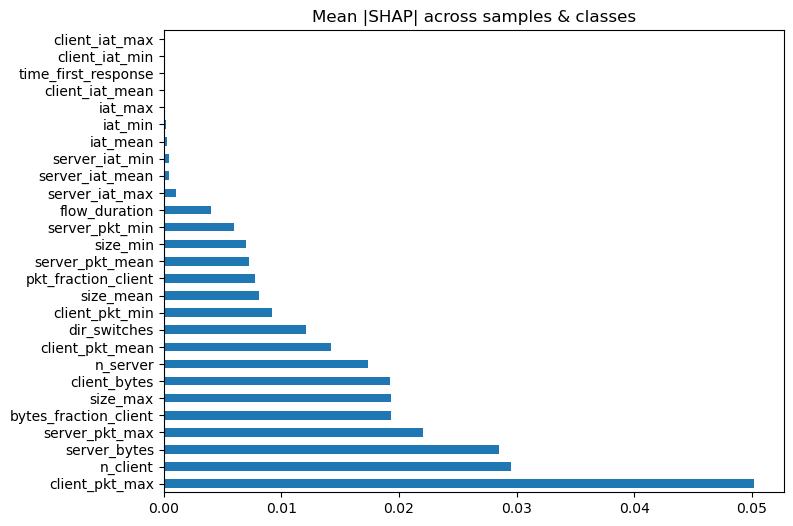

In [14]:
# mean absolute shap across samples and classes -> (n_features,)
mean_abs_shap_per_feat = np.mean(np.abs(shap_values), axis=(0, 2))

# build a pandas Series for display/sorting
import pandas as pd
features = X.columns.tolist()
feat_imp = pd.Series(mean_abs_shap_per_feat, index=features).sort_values(ascending=False)
print(feat_imp)

# bar plot of top 16 (or top N)
feat_imp.plot(kind='barh', figsize=(8,6), title="Mean |SHAP| across samples & classes")

In [7]:
import pandas as pd
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test  = pd.DataFrame(X_test,  columns=feature_names)
# Rank features
importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
# Select top 16
top_features = importances.head(16).index.tolist()
print("Top 16 features:", top_features)

Top 16 features: ['client_pkt_max', 'n_server', 'server_bytes', 'server_pkt_max', 'n_client', 'client_bytes', 'size_max', 'bytes_fraction_client', 'dir_switches', 'size_mean', 'pkt_fraction_client', 'client_pkt_mean', 'server_pkt_mean', 'size_min', 'client_pkt_min', 'server_pkt_min']


# RE TRAINING WITH REDUCED MODEL

In [10]:
 #Train MLP
# Extended MLP with more options
mlp_reduced = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # deeper network with 3 hidden layers
    activation="relu",                  # alternatives: 'tanh', 'logistic'
    solver="adam",                      # alternatives: 'sgd', 'lbfgs'
    alpha=1e-4,                         # L2 regularization (weight decay)
    batch_size=64,                      # mini-batch size
    learning_rate="adaptive",           # 'constant', 'invscaling', 'adaptive'
    learning_rate_init=0.001,           # initial learning rate
    max_iter=500,                       # train longer
    shuffle=True,                       # shuffle samples every epoch
    early_stopping=True,                # stop if validation score doesn’t improve
    validation_fraction=0.1,            # use 10% of training for validation
    n_iter_no_change=20,                # patience for early stopping
    random_state=42,                    # reproducibility
    verbose=True                        # print progress during training
)

mlp_reduced.fit(X_train[top_features], y_train)

# Evaluate
y_pred = mlp_reduced.predict(X_test[top_features])
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

Iteration 1, loss = 0.08640621
Validation score: 0.985648
Iteration 2, loss = 0.03717831
Validation score: 0.989025
Iteration 3, loss = 0.03173292
Validation score: 0.990916
Iteration 4, loss = 0.02830581
Validation score: 0.990697
Iteration 5, loss = 0.02639500
Validation score: 0.994563
Iteration 6, loss = 0.02483593
Validation score: 0.996083
Iteration 7, loss = 0.02410399
Validation score: 0.992048
Iteration 8, loss = 0.02289106
Validation score: 0.989937
Iteration 9, loss = 0.02320358
Validation score: 0.990781
Iteration 10, loss = 0.02186058
Validation score: 0.991034
Iteration 11, loss = 0.02143781
Validation score: 0.992267
Iteration 12, loss = 0.02081481
Validation score: 0.996015
Iteration 13, loss = 0.02025023
Validation score: 0.991524
Iteration 14, loss = 0.01903661
Validation score: 0.996674
Iteration 15, loss = 0.01821555
Validation score: 0.996640
Iteration 16, loss = 0.01708315
Validation score: 0.996302
Iteration 17, loss = 0.01636365
Validation score: 0.996674
Iterat

<Figure size 1000x800 with 0 Axes>

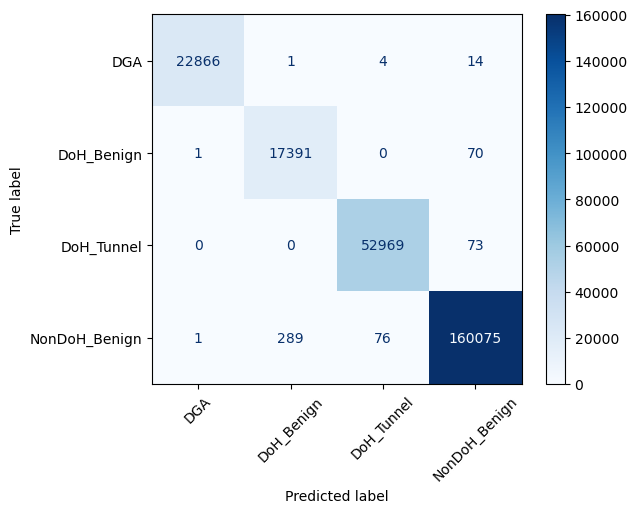

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [15]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Take only the top features you trained with
X_train_reduced = X_train[top_features]
X_test_reduced  = X_test[top_features]

# Use a small background set for SHAP (to speed up kernel explainer)
background = shap.utils.sample(X_train_reduced, 200, random_state=42)

# Create SHAP Kernel Explainer (model-agnostic, works for sklearn MLP)
explainer = shap.KernelExplainer(mlp_reduced.predict_proba, background)

# Explain predictions on a sample of test set (to save time)
X_sample = shap.utils.sample(X_test_reduced, 300, random_state=42)

# Compute shap values (multiclass: list of arrays, one per class)
shap_values = explainer.shap_values(X_sample)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


client_pkt_max           0.043583
server_bytes             0.041669
n_client                 0.022087
server_pkt_max           0.021020
client_bytes             0.019974
bytes_fraction_client    0.018233
size_max                 0.016840
n_server                 0.016099
size_mean                0.014178
server_pkt_mean          0.012894
pkt_fraction_client      0.011647
client_pkt_mean          0.010560
dir_switches             0.009874
size_min                 0.008719
client_pkt_min           0.007577
server_pkt_min           0.006665
dtype: float64


<Axes: title={'center': 'Mean |SHAP| across samples & classes'}>

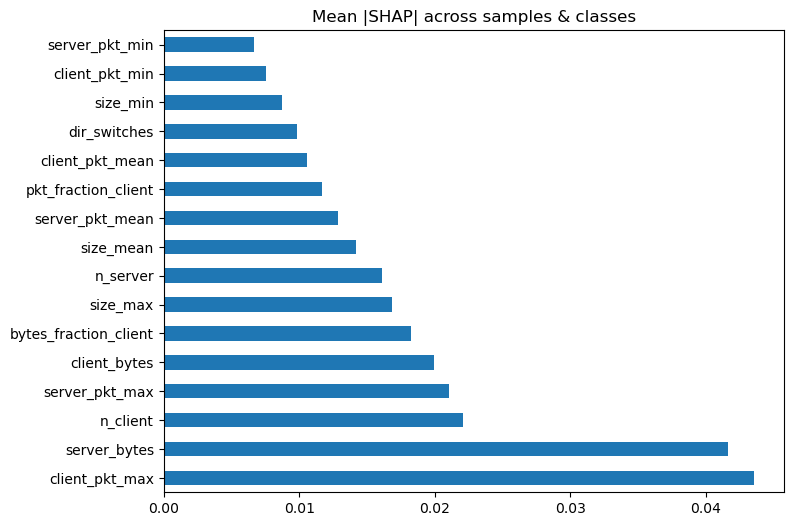

In [16]:

# mean absolute shap across samples and classes -> (n_features,)
mean_abs_shap_per_feat = np.mean(np.abs(shap_values), axis=(0, 2))

# build a pandas Series for display/sorting
import pandas as pd
feat_imp = pd.Series(mean_abs_shap_per_feat, index=top_features).sort_values(ascending=False)
print(feat_imp)

# bar plot of top 16 (or top N)
feat_imp.head(16).plot(kind='barh', figsize=(8,6), title="Mean |SHAP| across samples & classes")


Class: DGA


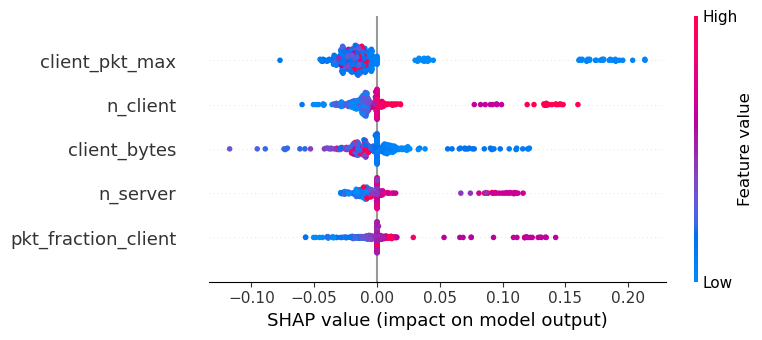

Class: DoH_Benign


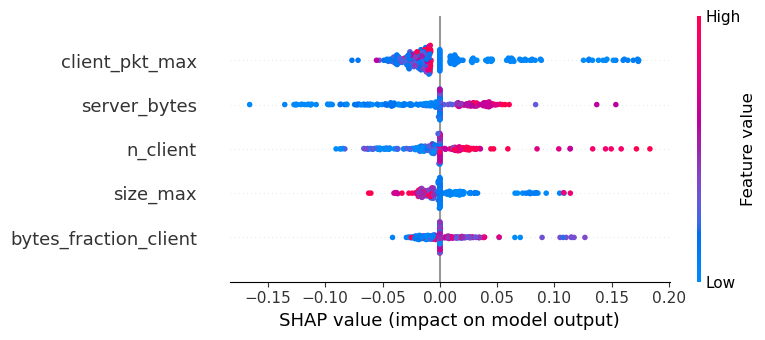

Class: DoH_Tunnel


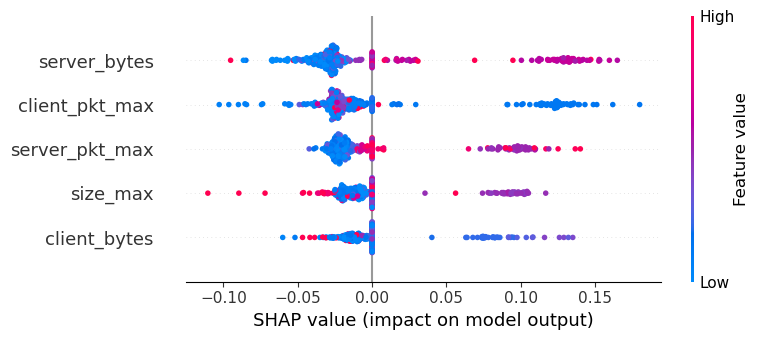

Class: NonDoH_Benign


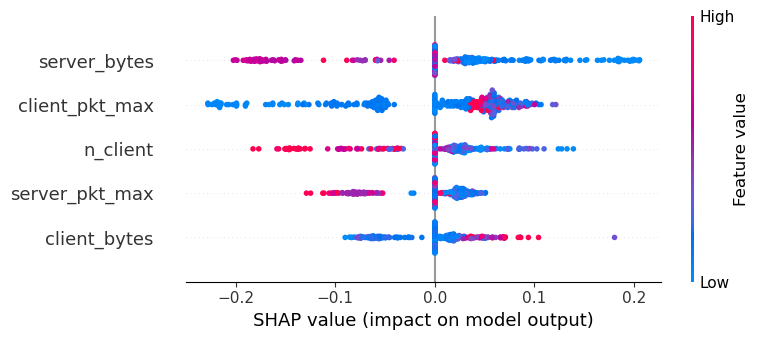

In [17]:
import matplotlib.pyplot as plt

for i, cname in enumerate(le.classes_):
    print("Class:", cname)
    shap.summary_plot(shap_values[:, :, i], X_sample, feature_names=top_features, show=True, max_display=5)
